In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
import torchvision.transforms as transforms
from PIL import Image
import timm  # для визуальных моделей

In [2]:
class VLMDataset(Dataset):
    def __init__(self, images, texts, transform=None, tokenizer=None, max_length=128):
        self.images = images  # Теперь это список PIL изображений, а не путей
        self.texts = texts
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Берем готовое PIL изображение
        image = self.images[idx]
        
        # Применяем преобразования если есть
        if self.transform:
            image = self.transform(image)
        
        # Токенизация текста
        text = self.texts[idx]
        if self.tokenizer:
            text_encoded = self.tokenizer(
                text, 
                max_length=self.max_length, 
                padding='max_length', 
                truncation=True, 
                return_tensors='pt'
            )
            input_ids = text_encoded['input_ids'].squeeze()
            attention_mask = text_encoded['attention_mask'].squeeze()
        else:
            input_ids, attention_mask = text, None
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'text': text
        }

class VisionLanguageModel(nn.Module):
    def __init__(self, vision_model_name='resnet50', text_model_name='bert-base-uncased', 
                 projection_dim=512, hidden_dim=768):
        super().__init__()
        
        # Визуальный энкодер
        self.vision_encoder = timm.create_model(
            vision_model_name, 
            pretrained=True, 
            num_classes=0  # Убираем классификатор
        )
        vision_feat_dim = self.vision_encoder.num_features
        
        # Текстовый энкодер
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_feat_dim = self.text_encoder.config.hidden_size
        
        # Проекционные слои
        self.image_projection = nn.Sequential(
            nn.Linear(vision_feat_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, projection_dim)
        )
        
        self.text_projection = nn.Sequential(
            nn.Linear(text_feat_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, projection_dim)
        )
        
        # Температурный параметр для контрастивной потери
        self.logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/0.07)))
    
    def forward(self, images, input_ids, attention_mask):
        # Кодируем изображения
        image_features = self.vision_encoder(images)
        image_embeddings = self.image_projection(image_features)
        
        # Кодируем текст
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        text_embeddings = self.text_projection(text_features)
        
        # Нормализуем эмбеддинги
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
        
        return image_embeddings, text_embeddings, self.logit_scale.exp()

def contrastive_loss(image_embeddings, text_embeddings, logit_scale):
    # Вычисляем similarity matrix
    logits_per_image = logit_scale * image_embeddings @ text_embeddings.t()
    logits_per_text = logit_scale * text_embeddings @ image_embeddings.t()
    
    # Labels - диагональная матрица (положительные пары)
    batch_size = image_embeddings.shape[0]
    labels = torch.arange(batch_size, device=image_embeddings.device)
    
    # Cross-entropy loss
    loss_i = nn.functional.cross_entropy(logits_per_image, labels)
    loss_t = nn.functional.cross_entropy(logits_per_text, labels)
    
    return (loss_i + loss_t) / 2

In [3]:
# Конфигурация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 1e-5
num_epochs = 5

# Трансформы для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [4]:
from datasets import load_dataset
dataset = load_dataset("Naveengo/flickr8k")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8091
    })
})


In [5]:
from tqdm import tqdm

images = []
texts = []

for item in tqdm(dataset['train']):
    images.append(item['image'])
    texts.append(item['text'])  # или item['sentences'][0] в зависимости от структуры

print(f"Загружено {len(images)} изображений")

100%|██████████| 8091/8091 [00:19<00:00, 416.67it/s]

Загружено 8091 изображений


In [6]:
# Токенизатор
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Загрузка данных (заглушка - нужно заменить на реальные данные)
# Предполагаем, что у нас есть списки путей к изображениям и соответствующих текстов
# image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", ...]  # ваш список
# texts = ["описание изображения 1", "описание изображения 2", ...]  # ваш список

dataset = VLMDataset(images, texts, transform, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.4134207].


A boy descends off the end of a high diving board .


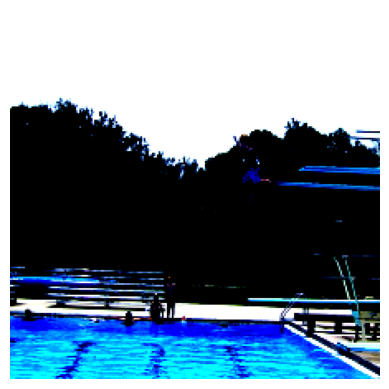

In [8]:
ind = 45
img = dataset[ind]['image']

# Преобразуем (3, 224, 224) -> (224, 224, 3)
img = img.permute(1, 2, 0)
print(dataset[ind]['text'])
plt.imshow(img)
plt.axis('off')  # отключить оси
plt.show()

In [9]:
# Модель и оптимизатор
model = VisionLanguageModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [10]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(dataloader):
        # Перемещаем данные на устройство
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        image_emb, text_emb, logit_scale = model(images, input_ids, attention_mask)
        
        # Вычисление потерь
        loss = contrastive_loss(image_emb, text_emb, logit_scale)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

  0%|          | 0/506 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Epoch [1/5], Loss: 1.7687


100%|██████████| 506/506 [03:42<00:00,  2.27it/s]


Epoch [2/5], Loss: 0.9732


100%|██████████| 506/506 [03:39<00:00,  2.31it/s]


Epoch [3/5], Loss: 0.7042


100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Epoch [4/5], Loss: 0.5492


100%|██████████| 506/506 [03:35<00:00,  2.35it/s]

Epoch [5/5], Loss: 0.4431


In [ ]:
def encode_text(text, model, tokenizer, device, normalize=True):
    # Токенизация текста
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        padding=True, 
        truncation=True, 
        max_length=128
    )
    
    # Перемещаем на устройство
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Кодируем текст
    with torch.no_grad():
        text_outputs = model.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Берем [CLS] токен как представление всего текста
        # Для BERT-like моделей это первый токен
        text_features = text_outputs.last_hidden_state[:, 0, :]
        
        # Проецируем в общее пространство
        text_embedding = model.text_projection(text_features)
        
        # Нормализуем (опционально)
        if normalize:
            text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    
    return text_embedding

In [15]:
def encode_image(images, model, device, normalize=True):
    if isinstance(images, Image.Image):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        images = transform(images).unsqueeze(0)
    
    images = images.to(device)
    
    with torch.no_grad():
        image_features = model.vision_encoder(images)
        
        image_embeddings = model.image_projection(image_features)
        
        if normalize:
            image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
    
    return image_embeddings

In [101]:
def search_images(query, image_embeddings_db, model, tokenizer, device):
    # Кодируем текстовый запрос
    text_emb = encode_text(query, model, tokenizer, device)
    
    # Ищем ближайшие изображения
    similarities = torch.matmul(image_embeddings_db, text_emb.T)
    top_matches = torch.topk(similarities, k=5, dim=0)
    
    return top_matches.indices

def zero_shot_classification(image, classes, model, tokenizer, device):
    """
    classes = ["кошка", "собака", "машина", "дерево"]
    """
    # Кодируем изображение
    image_emb = encode_image(image, model, device)
    
    # Кодируем все классы
    class_embs = []
    for class_name in classes:
        text_emb = encode_text(f"photo of: {class_name}", model, tokenizer, device)
        class_embs.append(text_emb.squeeze(0))
    
    class_embs = torch.stack(class_embs)
    
    # Вычисляем схожести
    similarities = torch.matmul(image_emb, class_embs.T)
    probabilities = torch.softmax(similarities, dim=-1)
    
    return dict(zip(classes, probabilities.tolist()[0]))

In [18]:
def create_image_embeddings_db(dataset, model, device):
    model.eval()
    image_embeddings = []
    
    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset, batch_size=16)):
            images = batch['image'].to(device)
            
            # Кодируем изображения
            image_features = model.vision_encoder(images)
            image_emb = model.image_projection(image_features)
            image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
            
            image_embeddings.append(image_emb.cpu())
    
    # Объединяем все эмбеддинги в один тензор
    image_embeddings_db = torch.cat(image_embeddings, dim=0)
    return image_embeddings_db

# Использование:
image_embeddings_db = create_image_embeddings_db(dataset, model, device)

100%|██████████| 506/506 [01:08<00:00,  7.43it/s]


In [ ]:
image_embeddings_db = image_embeddings_db.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.4831376].


A dog leaps down the road .


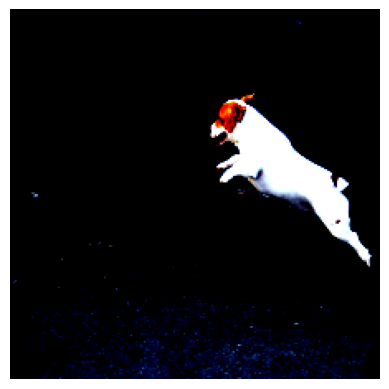

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


A brown and black puppy stands by a camera .


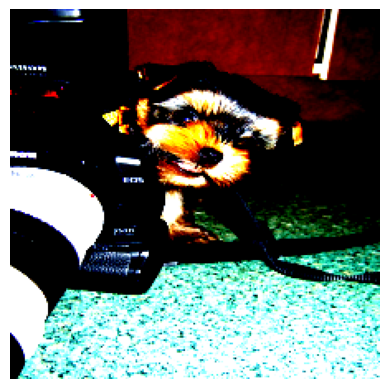

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6475817..2.5702832].


A brown dog wearing a collar is chasing and biting on a red broom .


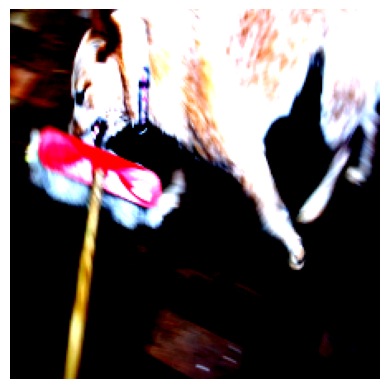

a dog playing ouside


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.2565577].


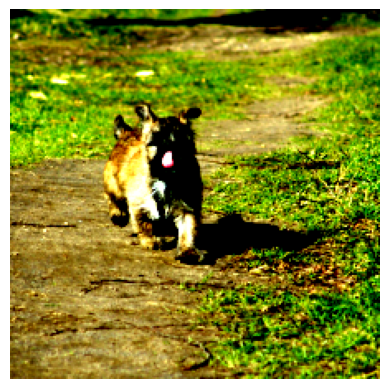

"A brown   black and white dog is on a obstacle course ."


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].


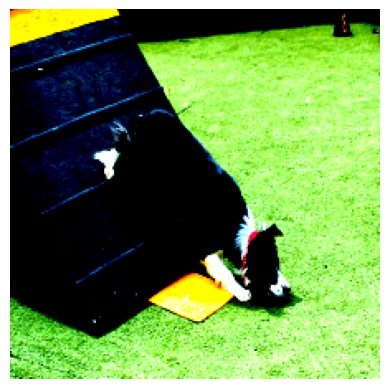

In [67]:
for ind in search_images('katze', image_embeddings_db, model, tokenizer, device):
    img = dataset[ind]['image']

    # Преобразуем (3, 224, 224) -> (224, 224, 3)
    img = img.permute(1, 2, 0)
    print(dataset[ind]['text'])
    plt.imshow(img)
    plt.axis('off')  # отключить оси
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


A young child raises her arms while jumping on a yellow blow-up toy .


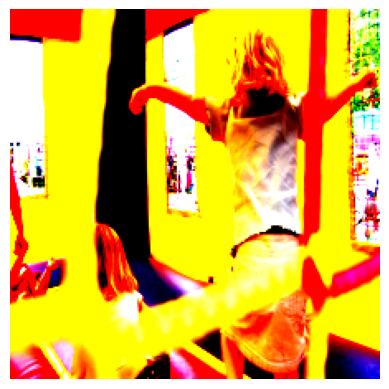

In [109]:
ind = 7852
img = dataset[ind]['image']

# Преобразуем (3, 224, 224) -> (224, 224, 3)
img = img.permute(1, 2, 0)
print(dataset[ind]['text'])
plt.imshow(img)
plt.axis('off')  # отключить оси
plt.show()

In [78]:
img.unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])

In [100]:
dict(zip(['water blue', "cat", "dog", "car", "tree"], [0.2374992072582245,
  0.16956162452697754,
  0.17299386858940125,
  0.21514621376991272,
  0.20479902625083923]))

{'water blue': 0.2374992072582245,
 'cat': 0.16956162452697754,
 'dog': 0.17299386858940125,
 'car': 0.21514621376991272,
 'tree': 0.20479902625083923}

In [113]:
ind = 7852
img = dataset[ind]['image']
zero_shot_classification(img.unsqueeze(dim=0), ['child', "cat", "dog", "car", "tree"], model, tokenizer, device)

{'child': 0.2227744609117508,
 'cat': 0.22268155217170715,
 'dog': 0.18614177405834198,
 'car': 0.20388995110988617,
 'tree': 0.1645122617483139}